In [1]:
%matplotlib ipympl

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation # For smoother animations

In [3]:
def initialize_fluid_cells(num_cells: int, channel_length: float):
    # --- Setup (you'll define these based on your problem) ---
    dx = channel_length / num_cells
    x_positions = np.linspace(0, channel_length - dx, num_cells) + dx / 2.0 # Cell centers
    return dx, x_positions

In [4]:
def initialize_dam(num_cells: int, h_low: float, h_high: float):
    h = np.zeros(num_cells)
    dam_position_idx = num_cells // 2
    h[:dam_position_idx] = h_high  # Deep water left
    h[dam_position_idx:] = h_low  # Shallow water right

    u = np.zeros(num_cells)
    return h, u

In [5]:
def one_step(state, dx, dt):
    h = state["h"]
    u = state["u"]
    h_new, u_new = np.zeros_like(h), np.zeros_like(u)
    for i in range(0, len(h)):
        # --- Update the state using the shallow water equations ---
        if i == 0:
            change_of_flux = h[i + 1] * u[i + 1] - h[i] * (-u[i])
            h_new[i] = 0.5 * (h[i+1] + h[i]) - (dt * change_of_flux) / (2 * dx)
        elif i == len(h) - 1:
            change_of_flux = h[i] * (-u[i]) - h[i - 1] * u[i - 1]
            h_new[i] = 0.5 * (h[i] + h[i-1]) - (dt * change_of_flux) / (2 * dx)
        else:
            change_of_flux = h[i + 1] * u[i + 1] - h[i - 1] * u[i - 1]
            h_new[i] = 0.5 * (h[i+1] + h[i-1]) - (dt * change_of_flux) / (2 * dx)

        if i == 0:
            du_dx = (u[i + 1] - (-u[i])) / (2 * dx)
            dh_dx = (h[i + 1] - h[i]) / (2 * dx)
            u_new[i] = 0.5 * (u[i+1] + (-u[i])) - dt * (9.81 * dh_dx + u[i] * du_dx)
        elif i == len(h) - 1:
            du_dx = ((-u[i]) - u[i - 1]) / (2 * dx)
            dh_dx = (h[i] - h[i - 1]) / (2 * dx)
            u_new[i] = 0.5 * ((-u[i]) + u[i-1]) - dt * (9.81 * dh_dx + u[i] * du_dx)
        else:
            du_dx = (u[i + 1] - u[i - 1]) / (2 * dx)
            dh_dx = (h[i + 1] - h[i - 1]) / (2 * dx)
            u_new[i] = 0.5 * (u[i+1] + u[i-1]) - dt * (9.81 * dh_dx + u[i] * du_dx)

    state["h"] = h_new
    state["u"] = u_new

In [6]:
def visualize(h, u, dx, dt, x_positions, frames=100, interval=50, steps_per_animation_frame=1):
    state = {'h': h, 'u': u}

    # --- Visualization Setup ---
    fig, ax = plt.subplots()
    line, = ax.plot(x_positions, h, color='blue') # The comma is important for FuncAnimation
    ax.set_xlabel("Position (x)")
    ax.set_ylabel("Water Height (h)")
    ax.set_title("1D Dam Break")
    ax.set_ylim(0, np.max(h) * 1.2) # Set y-axis limits based on initial max height

    # --- Simulation Loop (where you'd call your SWE solver) ---
    # This function will be called for each frame of the animation
    def animate(frame_num):
        if frame_num > 0: # Don't shift on the very first frame
            for _ in range(steps_per_animation_frame):
                one_step(state, dx, dt)
        line.set_ydata(state['h'])  # Update the data of the line
        ax.set_title(f"1D Dam Break - Time Step {frame_num}")
        return line,

    ani = animation.FuncAnimation(fig, animate, frames=frames, interval=interval, blit=True)
    plt.grid(True)
    plt.show()
    return ani

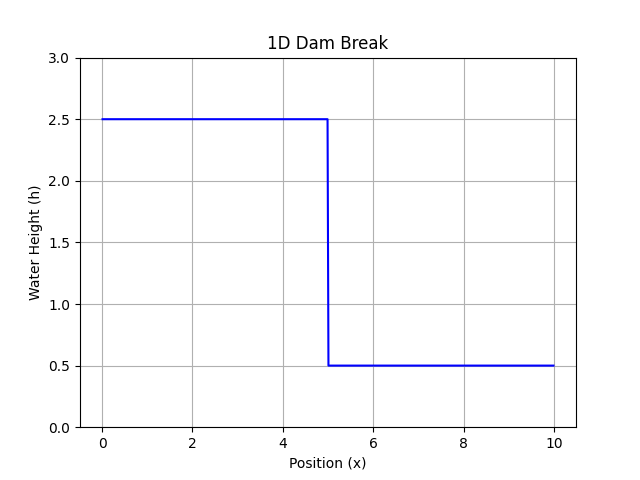

In [7]:
num_cells = 500
channel_length = 10.0
dx, x_positions = initialize_fluid_cells(num_cells, channel_length)
h_low = 0.5
h_high = 2.5
h, u = initialize_dam(num_cells, h_low, h_high)
dt = 0.001
frames = 2000
interval = 1  # milliseconds between frames
steps_per_animation_frame = 20

ani = visualize(h, u, dx, dt, x_positions, frames, interval, steps_per_animation_frame)

In [8]:
ani.pause()
ani.save('dam_break_animation.mp4', writer='ffmpeg', fps=60)